# Pairs Trading Enhancements

By James Zhang and Sam Galita |  Smith Investment Fund  |  Spring 2023

<hr/>

# Introduction

Pairs trading is a type of mean reversion trading strategy first introduced by technical analyst researchers at Morgan Stanley in the mid-1980s. On a high level, pairs trading involves matching a long position with a short position in two highly cointegrated stocks. A statistical tool often used in timeseries analysis, cointegration measures the degree to which two time series' means trend together. In pairs trading, we apply cointegration on the difference of prices between two stocks, otherwise known as the spread, to detect assets that tend to trend similarly. One of the main advantages of this strategy is market neutrality. Since traders are trading the spread between two assets and not individual assets, a pairs trader can find statistical arbitrage opportunities regardless of market direction. In other words, we should not expect better or worse performance during economic downswings. Furthermore, traders remain delta neutral when using this strategy, making pairs trading relatively low risk, and theoretically less volatile than a market-following strategy. As a result of this risk advantage, many hedge funds have historically leveraged pairs trading, despite it's low relative returns. However, this strategy is widely known in the modern market and would likely not provide high returns in a real market setting. Despite this, pairs trading sets the groundwork for further research into statistical arbitrage and remains an interesting topic for research.
After two cointegrated stocks are identified, if a cointegration discrepancy occurs - when the spread between two securities diverges from their historical rolling mean and beyond some threshold - the trader invests a dollar-matched long position in the underperforming security and short position in the overperforming security. If the spread between these assets does indeed reconverge, which is expected due to the identified relationship between pairs, traders will make a profit.
One of the keys to successful Pairs Trading is being able to efficiently detect pairs. In a notebook published a few months ago, Abhi designed and applied a basic pais trading strategy to the equity and crypto markets. In our notebook, We propose enhancements to last semester's Pairs Trading work done by Abhi. First, we will apply Principal Component Analysis (PCA) and clustering to the pricing timeseries', exploring a variety of clustering methods in the process. Within each cluster, we will then perform cointegration tests to identify pairs. Because of the use of clustering and PCA, we expect to find a reduction in needed computation time, thus allowing us to use a larger universe size when backtesting, which theoretically will allow us to compute more profitable pairs. Furthermore, we will also explore a variety of parameter optimizations for the strategy, specifically with respect to lookback, reset frequency of pair selection, and zscore cutoffs. Lastly, we will also explore the idea of using the hurst exponent as an additional criteria when selecting pairs.

## Required Imports

Below is some more information about some of the more fundamental libraries if you want to learn more.

- <a href="https://numpy.org/doc/">NumPy</a>
- <a href="https://pandas.pydata.org/docs/">Pandas</a>
- <a href="https://matplotlib.org/stable/index.html">Matplotlib</a>
- <a href="https://scikit-learn.org/stable/index.html">Sklearn</a>
- <a href="https://www.statsmodels.org/stable/index.html">Statsmodels</a>

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import random
import sys
from collections import Counter
import time
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from statsmodels.tsa.stattools import coint
from IPython.core import display as ICD
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union
array_1d = Union[List, Tuple, pd.Series, np.ndarray]
date_obj = Union[datetime.datetime, datetime.date]
import requests
import bs4 as bs
import functools
import hyperopt
import warnings
warnings.filterwarnings('ignore')  # Disable warnings to reduce output spam in notebook

from sif.siftools.backtesters import full_backtesters as fb
from sif.siftools import operators as op
from sif.siftools import metrics as metrics
from sif.sifinfra import sif_utils as su
from sif.siftools.abstractalpha import AbstractAlpha
from sif.sifinsights import alpha_search
from sif.sifinsights.alpha_search import apply_metric_func
from sif.pairstrading.alphas_v2 import SMRPairsTrader
from sif.pairstrading.alphas_v2 import Cluster

We initialize multiple backtesters from the SIF Infrasture that will allow us to test our Pairs Trading Strategies in sample from 2000-2015 and out of sample from 2016-2020. Note that we can save them locally to save time each time we want to test our alphas.

In [3]:
# *** IN SAMPLE BACKTESTER WITH UNIVERSE REBALANCING *** #
start_date_15y = datetime.datetime(2000, 1, 1)
end_date_15y = datetime.datetime(2015, 12, 31)
# backtester_15y = fb.FullMultipleBacktester(
#     start_date_15y,

#     end_date_15y,
#     'M',
#     273,
#     universe_size = 500, 
#     factors=['close', 'sector']
# )
# backtester_15y.save_local('pairs_15y.npy')
backtester_15y = fb.FullMultipleBacktester.from_local('sif/pairstrading/pairs_15y.npy')
sp_data = su.get_sp_close(start_date_15y, end_date_15y)  # Also pull S&P data for use later
sp_ret = sp_data.pct_change()

In [4]:
# *** OUT OF SAMPLE BACKTESTER WITH UNIVERSE REBALANCING *** #
start_date_5y = datetime.datetime(2016, 1, 1)
end_date_5y = datetime.datetime(2020, 12, 31)
# backtester_5y = fb.FullMultipleBacktester(
#     start_date_5y,
#     end_date_5y,
#     'M',
#     273,
#     universe_size = 500, 
#     factors=['close', 'sector']
# )
# backtester_5y.save_local('pairs_5y.npy')
backtester_5y = fb.FullMultipleBacktester.from_local('sif/pairstrading/pairs_5y.npy')

In [5]:
# *** GET ROLLING SHARPE RATIO HELPER FUNCTION *** #
def get_rolling_sharpe(returns):
    rolling_sharpe = functools.partial(metrics.rolling_metric, func=metrics.sharpe_ratio, window=252)
    returns.apply(rolling_sharpe).plot()
    plt.title('1 Year Rolling Sharpe Ratio')
    plt.show()

# *** GET OTHER SUMMARY ANALYTICS HELPER FUNCTION *** #
def get_analytics(alphas, returns, holdings):
    perf_tables = apply_metric_func(metrics.generate_performance_table, ('daily_returns', 'holdings'))(returns, holdings)
    for alpha, table in zip(alphas, perf_tables):
        print(f"{alpha.name}")
        ICD.display(table)
        print()

## Previous Work and Novelties

SIF Researcher Abhinav Modugula worked on Pairs Trading for much of last semester. Our work in this notebook builds on top of his initial research. You can read his work here: https://www.smithinvestmentfund.com/blog/crypto-pairs-trading. His initial work on Pairs Trading should be read before the rest of this notebook.

### Selecting Pairs and Weights

As a baseline metric, we present brute force pairs trading alphas without dimensionality reduction, machine learning enhancements, additional trading criteria, or parameter optimization. These alphas are based off of Abhi's original alphas, with notable fixes to certain bugs.

For both of the following alphas, we test for cointegration between the price time series of two securities using the `Statsmodels` implementation of the Engel-Granger Test, which outputs a pvalue that can be used to either accept or reject the null hypothesis that the two secrities are cointegrated. The first alpha takes all of the statistically significant pairs between the 500 securities in the universe and randomly selects 10 to trade off of. Extracting random pairs out of all the generated pairs can possibly be improved, however, by choosing the lowest pvalue pairs. The second alpha implements this idea. 


See the implementation below of the Random pairs trading strategy explained in the introduction. The lowest pvalue strategy can be found in the alphas.py file.

### Parameters

For this inital strategy, we rechoose pairs every 90 days and select 10 pairs to trade on. The universe size is 500, and we enter trades when the magnitude of the zscore of the difference of prices is above 1.5 and exit when it is below 1.0

We've implemented a pairs trading alpha in the `alphas.py` that allows researchers to customize the pairs selection and trading methodology process with various enhancements that we will discuss later in the blogpost.

  0%|          | 0/2 [00:00<?, ?it/s]

Done!: 100%|██████████| 2/2 [13:08<00:00, 394.48s/it]        


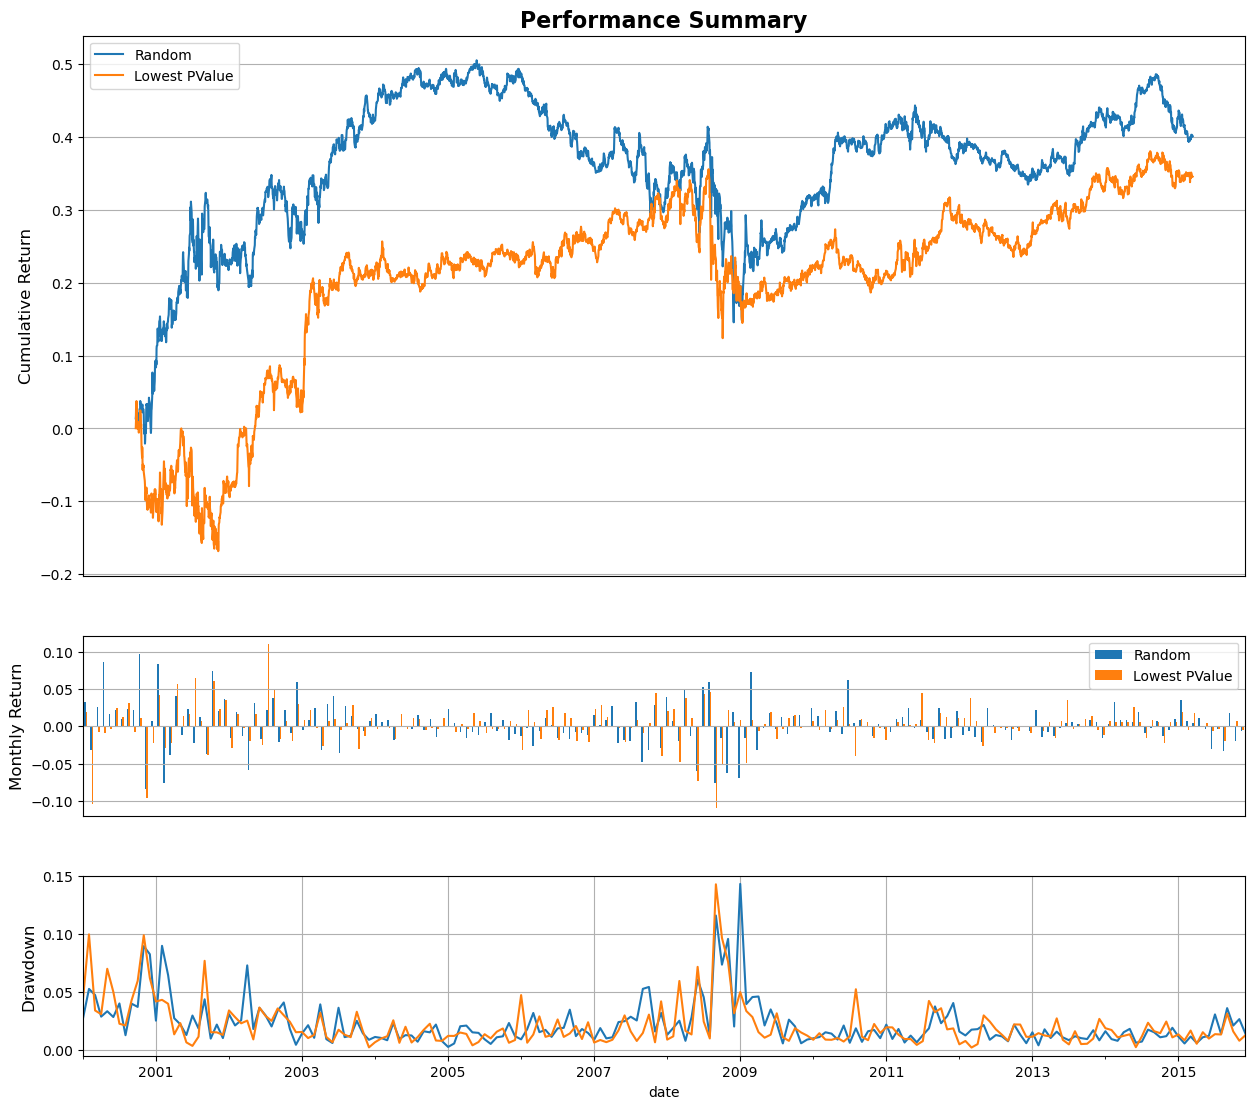

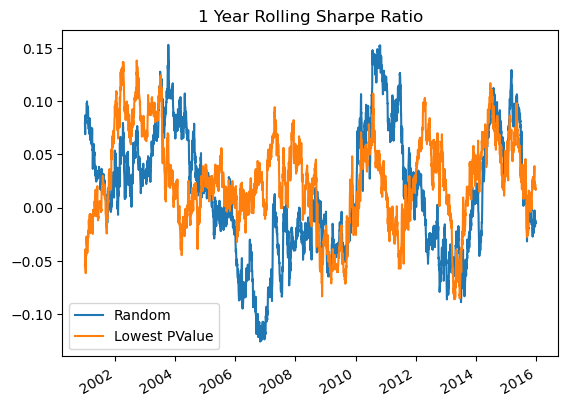

Random


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2000,0.226420,1.254912,2.008239,0.107234,0.211276,7.166667,6.166667
2001,0.105243,0.749077,1.197473,0.128001,0.168359,7.532258,6.532258
2002,0.057791,0.510485,0.917145,0.097009,0.158827,7.805556,6.805556
2003,0.070252,1.061170,1.612321,0.039808,0.179608,7.325397,6.325397
2004,0.013531,0.262715,0.461257,0.034959,0.170198,7.825397,6.825397
2005,-0.016486,-0.333371,-0.504661,0.054601,0.146173,8.023810,7.023810
2006,-0.103971,-1.881004,-2.757241,0.097870,0.164210,7.382470,6.382470
2007,-0.053321,-0.614390,-0.970419,0.113914,0.168112,7.569721,6.569721
2008,-0.019959,-0.121260,-0.179590,0.180996,0.131013,8.256917,7.256917



Lowest PValue


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2000,-0.150949,-0.846398,-1.303030,0.184798,0.183296,7.761905,6.761905
2001,0.230592,1.644633,2.645892,0.086158,0.212882,7.161290,6.161290
2002,0.119564,1.046560,1.659582,0.063730,0.204471,7.095238,6.095238
2003,0.015323,0.258732,0.383262,0.054594,0.200837,7.400794,6.400794
2004,0.016276,0.311137,0.599405,0.035709,0.170931,7.416667,6.416667
2005,0.007558,0.153606,0.248840,0.033320,0.157702,7.706349,6.706349
2006,-0.007260,-0.109542,-0.190770,0.048886,0.176345,7.458167,6.458167
2007,0.052095,0.919383,1.402570,0.042965,0.165016,7.637450,6.637450
2008,-0.068583,-0.425994,-0.526539,0.211868,0.147180,7.822134,6.822134


In [5]:
Random = SMRPairsTrader(reset=90, npairs=10, enter=1.0, exit=0.5, use_random=True, full_universe = False)
Random.name = "Random"
LowestPValue = SMRPairsTrader(reset=90, npairs=10, enter=1.0, exit=0.5, full_universe=False)
LowestPValue.name = "Lowest PValue"
alphas = [Random, LowestPValue]
returns, holdings = backtester_15y.backtest(alphas, processes=8)
metrics.summary_plot(returns, source=['Random', 'Lowest PValue'])
get_rolling_sharpe(returns)
get_analytics(alphas, returns, holdings)

# Method and Approach

Before we build the alphas for our improvements, we will apply the alterations that we wish to implement to a dataset of pricing data from the SIF database. This will help us build the framework for implementing our enhanced strategy in the alpha environment.

## Data Collection and Preprocessing

We use Beautiful Soup to scrape Wikipedia for a list of tickers, company names, and industries for companies in the S&P500, a stock market index tracking stock performance of 500 large, public companies traded in America.

In [5]:
#Send a GET request to the Wikipedia API that returns an html page.
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies') 
#Parse the webpage from Wikipedia with BeautifulSoup.
soup = bs.BeautifulSoup(resp.text, "html.parser")
# Find the contents under the "table" tag.
table = soup.find('table', {'class': 'wikitable sortable'})
# Store respective information.
tickers, names, industries = [], [], []
#Iterates through each row in the table excluding the header and extracts relevant data.
for row in table.findAll('tr')[1:]:
    tickers.append(row.findAll('td')[0].text)
    names.append(row.findAll('td')[1].text)
    industries.append(row.findAll('td')[3].text)
NUM_INDUSTRIES = len(Counter(industries))
# Delete newline characters in the parsed data.
tickers = [s.replace('\n', '') for s in tickers]
# Create a DataFrame of tickers, names and industries.
stock_info = pd.DataFrame({'Ticker': tickers, 'Name': names, 'Sector': industries}) #Create Dataframe from Wikipedia data
# Clean messy data.
stock_info = stock_info.replace('Communication Services\n','Communication Services')
# Sort alphabetically by the ticker.
stock_info = stock_info.sort_values(by=['Ticker'], ignore_index = True)
display(stock_info)
print(f"Number of stocks in stock_info: {stock_info.shape[0]}.")

,Ticker,Name,Sector
0,A,Agilent Technologies,Health Care Equipment
1,AAL,American Airlines Group,Passenger Airlines
2,AAP,Advance Auto Parts,Automotive Retail
3,AAPL,Apple Inc.,"Technology Hardware, Storage & Peripherals"
4,ABBV,AbbVie,Pharmaceuticals
...,...,...,...
498,YUM,Yum! Brands,Restaurants
499,ZBH,Zimmer Biomet,Health Care Equipment
500,ZBRA,Zebra Technologies,Electronic Equipment & Instruments
501,ZION,Zions Bancorporation,Regional Banks


Number of stocks in stock_info: 503.


Use the SIF Infrastructure to get close price data for all available tickers from January 1, 2015 to December 31, 2015.

In [6]:
start_date = datetime.datetime(2015, 1, 1)
end_date = datetime.datetime(2015, 12, 31)
equity_data = su.get_equity_data(tickers=tickers, 
                                 start_date=start_date, 
                                 end_date=end_date, 
                                 attributes=['close'])
close_data = equity_data["close"] 
close_data = close_data.fillna(method="ffill")
close_data = close_data.fillna(method="bfill")         
close_data = close_data.resample("D").ffill().reset_index()
close_data = close_data.set_index("date")
close_data.head()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,40.56,53.910,158.56,27.332,65.89,90.46,44.90,19.497,88.84,72.34,...,146.89,36.12,92.83,51.93,38.08,72.35,112.59,77.43,28.29,43.31
2015-01-03,40.56,53.910,158.56,27.332,65.89,90.46,44.90,19.497,88.84,72.34,...,146.89,36.12,92.83,51.93,38.08,72.35,112.59,77.43,28.29,43.31
2015-01-04,40.56,53.910,158.56,27.332,65.89,90.46,44.90,19.497,88.84,72.34,...,146.89,36.12,92.83,51.93,38.08,72.35,112.59,77.43,28.29,43.31
2015-01-05,39.80,53.875,156.47,26.562,64.65,89.69,44.91,19.380,87.34,71.98,...,144.39,35.71,90.29,51.57,35.71,70.88,116.79,76.34,27.23,43.05
2015-01-06,39.18,53.040,156.36,26.565,64.33,90.18,44.40,19.423,86.71,70.53,...,141.31,35.90,89.81,50.93,35.50,70.01,115.80,75.79,26.19,42.63


# Optimizing Pair Selection

- Dimensionality reduction using principal component analysis

- Clustering using KMeans, DBSCAN, and OPTICS

## Principal Component Analysis (PCA)

Principal component analysis is a mathematical procedure used to reduce the number of features in a dataset into a smaller number of uncorrelated variables known as "principal components," while preserving as much information as possible within the original dataset. This process takes us one step closer to easing computation and efficiently finding profitable pairs, as it reduces the amount of time it takes to perform clustering while retaining most of the information contained in the original dataset.

Primarily, PCA asks the question, how can we position all of these points (data) on new axes such that the maximum amount of information is retained? In other words, what direction axes can we choose to retain the the most information? Note that projecting points onto a pre-defined axis like the x-axis or y-axis (in a 2D example) is wasteful, since we lose all information from other potential axes. Projecting of a point $x$ onto a unit vector $u$, we obtain that the magnitude of the new point $x'$ is the inner product $x' = x^Tu$. Now suppose that the inner product squared $(x^Tu)^2$ represents the amount of information preserved after projection.

Back to our problem, suppose $X$ is the set of all points and $x_i \in X$. Maximizing the preserved information means we want to obtain $\max \sum (x_i^Tu)^2$, and we can use the Lagrange Multipliers Method to find this maximum.
Suppose we want to maximize the function $f(u) = \sum(x_i^Tu)^2$ given the constraint $g(u) = u^Tu = 1$. Note that this constraint forces $u$ to be a unit vector because we are trying to find the direction of the axis that preserves the most information. Therefore, the magnitude is irrelevant.
$$f(u) = \sum(x_i^Tu)^2$$
$$f(u) = \sum(x_i^Tu)(x_i^Tu)$$
$$f(u) =  u^T\sum(x_i)(x_i^Tu)$$
$$f(u) =  u^TC u \implies C = \frac{1}{n}\sum_i x_ix_i^T$$
where $C$ is the covariance matrix of the Function. Now let us use Lagrange Multipliers.
$$X - \lambda I = 0$$
$$u^TCu - \lambda(u^Tu-1)$$
Now take the gradient with respect to $u$.
$$2Cu - 2\lambda u \implies Cu = \lambda u$$

$u$ is the eigenvector and $\lambda$ is the eigenvalue. It becomes evident that the first principal component is the eigenvector of the covariance matrix with the largest eigenvalue. As for the second component, we want to find a direction that contains information that the first line doesn't. Thus, the second component should be orthogonal to the first, and since we are maximizing the same function with the same constraint, we find that the second component is simply the eigenvector with the second largest component. Generally, $N$ directions means $N$ covariance matrix eigenvectors and eigenvectors with each corresponding eigenvalue determining how important that component is.


**For those less familiar with linear algebra, but have a basic understanding of its uses, one can understand this to be similar to performing a change of bases on our data, with the intention of selecting bases that allow us to use less datapoints to represent the same information. As an example, if we have two days that for each stock in our universe, have nearly identical/scaled returns as the other day, we can use a single axis to record that information, reducing the dimensionality of our data (there is no point in keeping 2 axes if that information can be stored on a single axis)**

In [7]:
# Note that we have to transpose rets to obtain a DataFrame of shape n_samples, n_features.
rets = close_data.pct_change().dropna()
rets = rets.T
# Reduce dimensionality and preserve at least 90% of original information.
pca = PCA(n_components = 0.9, svd_solver='full')
transformed_data = pca.fit_transform(rets)
# Print out some information.
print("Shape of our data:", close_data.shape)
print("Total Preserved Information:", sum(pca.explained_variance_ratio_))
display(pd.DataFrame(transformed_data))
pca_info = pd.DataFrame({'Singular Values': pca.singular_values_,
                         'Explained Variance': pca.explained_variance_,
                         'Explained Variance Ratio': pca.explained_variance_ratio_}) 
print("Reduced dimensions shape of our new data:", transformed_data.shape)
display(pca_info)

Shape of our data: (364, 482)
Total Preserved Information: 0.9008118412488154


,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,0.010963,0.022158,-0.009898,0.009889,-0.015058,-0.017273,0.001319,-0.013328,-0.009345,-0.006460,...,0.005652,0.002382,-0.004311,0.018573,0.013396,-0.012600,0.021075,-0.001657,-0.013719,-0.001320
1,-0.080609,0.079218,0.025968,0.023544,0.056722,0.070680,-0.003803,-0.003440,0.072052,0.000652,...,0.001616,-0.008073,0.003189,-0.000027,0.020447,-0.011544,-0.005229,0.003148,-0.013230,0.014454
2,-0.015554,0.005958,-0.017067,0.017097,-0.021151,0.007100,-0.024113,0.006747,0.003870,-0.002081,...,0.012492,-0.002363,0.009082,-0.018592,-0.014923,0.007649,-0.022911,0.024359,0.003419,-0.001898
3,0.000816,0.042706,-0.011687,-0.025790,0.038154,-0.006921,0.011047,0.018085,-0.005666,0.002558,...,0.001818,-0.000514,0.010369,-0.006737,0.004544,-0.007099,0.002206,-0.016839,-0.015858,0.003175
4,-0.013444,0.024398,0.003271,0.099655,-0.053650,-0.055343,-0.038940,0.006127,-0.028259,-0.016237,...,0.011457,-0.007173,-0.013009,-0.003835,-0.003544,-0.005899,-0.002840,-0.004739,0.016956,-0.002141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,-0.040706,0.026161,0.015080,-0.002762,-0.021018,-0.027325,0.002841,-0.017084,0.000226,-0.000990,...,0.000576,-0.002440,-0.007259,0.010157,-0.009618,-0.024124,0.006573,0.011984,-0.008950,-0.005353
478,-0.029243,-0.009183,-0.005121,0.034833,-0.037150,-0.019190,-0.018274,-0.005992,-0.033584,0.004230,...,0.005866,-0.002300,-0.002446,0.007333,0.004543,-0.000513,-0.008124,0.003840,-0.000266,-0.009047
479,0.097166,0.088887,-0.000659,0.030460,0.047818,-0.052476,-0.026041,0.002690,-0.079675,0.021956,...,0.012333,-0.001349,-0.004156,-0.000159,-0.004909,-0.017304,-0.005935,0.003700,0.000699,0.001644
480,0.073809,0.056864,-0.067649,-0.076310,-0.073909,-0.003767,-0.011939,-0.006992,-0.027661,0.013197,...,-0.000643,-0.013520,-0.005331,-0.010114,-0.007036,-0.006105,0.000603,-0.010737,0.001986,0.007435


Reduced dimensions shape of our new data: (482, 114)


,Singular Values,Explained Variance,Explained Variance Ratio
0,1.481999,0.004566,0.084051
1,1.164183,0.002818,0.051867
2,1.034458,0.002225,0.040952
3,0.917165,0.001749,0.032191
4,0.828936,0.001429,0.026296
...,...,...,...
109,0.224150,0.000104,0.001923
110,0.223886,0.000104,0.001918
111,0.221366,0.000102,0.001875
112,0.219997,0.000101,0.001852


The below scree plot illustrates how each following principal component vector contains less information than the vector before it.

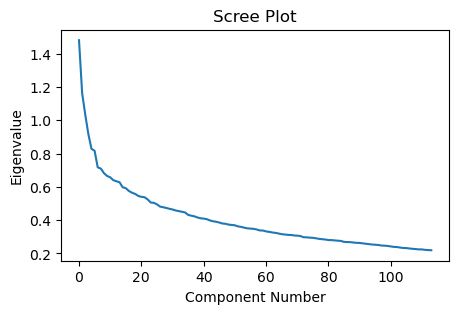

In [10]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(pca_info['Singular Values'])
ax.set_title('Scree Plot')
ax.set_xlabel('Component Number')
ax.set_ylabel('Eigenvalue')
fig.show()

## Clustering Methods

For our use purposes, clustering securities based on their percent returns gives us an insight into which companies are affected by similar factors ie. which securites are likely to be cointegrated with one another. This is critical for reducing the computation time of our strategy, as rather than computing, for example, 500 x 499 cointegration tests for a universe of size 500 stocks, if we can instead identify 20 clusters, each with 25 stocks, we reduce the number of cointegration tests nesseccary to $20 \times 25^2$, which is roughly 95% less computation. We will investigate three clustering algorithms - `KMeans`, `DBSCAN`, and `OPTICS`, to see which is most useful for this implementation.

### K-Means
K-Means clustering aims to partition data into $k$ clusters such that Euclidean distances within a cluster are minimized and distances between clusters are maximized. Traditionally, the elbow method is employed to determine the optimal number of $k$ clusters, where we determine the optimal number for $k$ based on the incremental reduction in distortion attained from further increasing k.

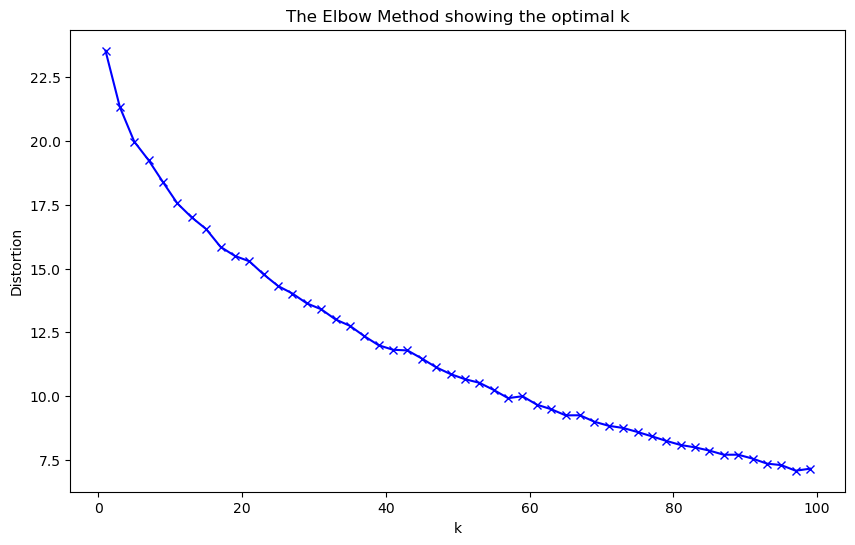

In [11]:
distortions = []
K = range(1, 100, 2)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(transformed_data)
    distortions.append(kmeans.inertia_)
plt.figure(figsize=(10,6))
plt.plot(K, distortions, '-bx')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The K-Means algorithm is as follows:

Suppose we have $n$ input data points $x_1, \cdots, x_n$ and our predetermined value of `k = 11` industries.
1. Randomly select `k` of the $n$ data points, and let them be the `k` centroids of the `k` clusters. 
2. For each point in the data, determine the Euclidean distance from the point to the `k` centroids.
Note that the Euclidean Distance between two points $a, b \in \mathbb{R}^n$ is defined as the following: $$\text{distance}(\textbf{a}, \textbf{b}) = \sqrt{(a_1-b_1)^2 + \cdots + (a_n-b_n)^2}$$
3. Let each cluster centroid be denoted as $c_i \in C$ where $C$ is the set of all centroids, then each data point $x_i$ is assigned to the closest cluster defined by the above Euclidean distance, or $$\text{arg min}_{c_i\in C} \ \text{distance}(c_i, x)$$
4. Define the new centroid of the current cluster by taking the average of the points in the cluster. Let $S_i$ be the ith cluster. Then the new centroid is defined as $$c_i = \dfrac{1}{|S_i|}\sum_{x_i \in S_i} x_i$$ such that $S_i$ is the size of set $S_i$.
5. Continue to iterate through the input data points until the `k` centroids don't change. 

Note that before we implement KMeans, we must define a common function that all clustering algorithms will use to identify cointegrated pairs within the universe. 

In [12]:
def engle_granger_cointegration(df: pd.DataFrame, labels: List[int]) -> Dict:
    n = df.shape[1]
    keys = df.keys()
    pairsDict = {}
    # Iterate through our universe.
    for i in range(n):
        for j in range(i + 1, n):
            # Assert that both stocks are in the same cluster and not outliers.
            if labels[i] != -1 and labels[j] != -1 and labels[i] == labels[j]:
                # Isolate both stocks and drop NaNs.
                S1 = close_data[keys[i]]        
                S2 = close_data[keys[j]]
                coint_df = pd.DataFrame({"S1": S1, "S2": S2}).dropna()
                S1 = coint_df["S1"]
                S2 = coint_df["S2"]
                # If either time series is constant, we don't want to trade it.
                # This can happen if a stock gets frozen on an exchange.
                if S1.nunique() > 1 and S2.nunique() > 1:
                    pvalue = coint(S1, S2)[1]
                    # If they are cointegrated, add it to our dictionary.
                    if pvalue < 0.05:
                        pairsDict[(keys[i], keys[j])] = pvalue
    # Sort the pairs by lowest p-value
    keys = list(pairsDict.keys())
    values = list(pairsDict.values())
    sorted_value_index = np.argsort(values)
    sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
    return pd.DataFrame({'Pairs': sorted_dict.keys(), "PValues": sorted_dict.values()})

## Elbow Method vs. Industries
While the elbow method is widely used in research, we realized there were practical limitations when trying to determine when additional distortion is small enough to warrant selecting a value for $k$. Thus, we decided to instead use the number of industries (11) as our $k$.

In [13]:
def kmeans_cluster(transformed_data: np.ndarray, nclusters: int) -> List[int]:
    kmeans = KMeans(n_clusters = nclusters)
    labels = kmeans.fit_predict(transformed_data)
    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # Number of noise points.
    n_noise = list(labels).count(-1)
    # Show which tickers are in which clusters.
    clusters = {}
    for i in range(len(labels)):
        if labels[i] != -1:
            clusters[labels[i]] = clusters.get(labels[i], "") + str(tickers[i]) + " "
    clusters = dict(sorted(clusters.items(), key=lambda x:x[0]))
    # Print out information about the kmeans clusters.
    print("Estimated number of clusters:", n_clusters)
    print("Estimated number of noise points:", n_noise)
    cluster_info = pd.DataFrame({'Cluster': clusters.keys(), 'Stocks': clusters.values()})
    cluster_info = cluster_info.set_index('Cluster')
    display(cluster_info.head(10))
    return labels

start_kmeans = time.perf_counter()
labels_kmeans = kmeans_cluster(transformed_data, 11)
pairs_kmeans = engle_granger_cointegration(close_data, labels_kmeans)
end_kmeans = time.perf_counter()
print(f"Time it takes KMEANS to generate pairs in a 500 stock universe size: {end_kmeans - start_kmeans}")
print(f"KMeans found {len(pairs_kmeans)} pairs.")
pairs_kmeans.head()

Estimated number of clusters: 11
Estimated number of noise points: 0


,Stocks
Cluster,
0,MMM ABBV ACN ARE ALGN GOOG AEP AXP AMT AWK AME...
1,AES AFL ALB GOOGL AMD AEE AAL APH ANSS APTV AZ...
2,PHM
3,AKAM ALK AON APA AMAT ANET BKNG CNP CF CHD CMC...
4,AOS ABT ATVI ADM ADBE ADP AAP A APD ALLE LNT A...
5,MET
6,DIS
7,AMGN CHTR CME CTSH DHI DG DOV EA LLY FIS FTNT ...
8,DXC


Time it takes KMEANS to generate pairs in a 500 stock universe size: 612.4769604
KMeans found 2765 pairs.


,Pairs,PValues
0,"(ATVI, STZ)",0.000003
1,"(ANSS, EA)",0.000005
2,"(GPC, WY)",0.000007
3,"(STE, VFC)",0.000011
4,"(RF, ZTS)",0.000012


,0,1,2
0,ATVI,Activision Blizzard,Interactive Home Entertainment
1,STZ,Constellation Brands,Distillers & Vintners


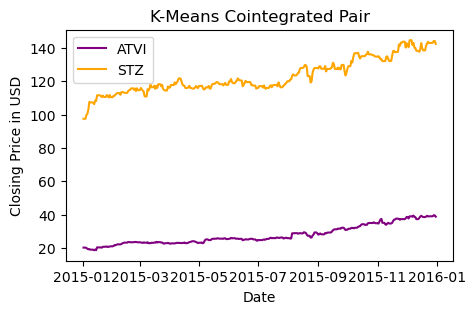

In [20]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(close_data['ATVI'], label = 'ATVI', color='purple')
ax.plot(close_data['STZ'], label = 'STZ', color='orange')
ax.set_title('K-Means Cointegrated Pair')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price in USD')
ax.legend()
fig.show()

ATVI_STZ = [(tickers[i], names[i], industries[i]) for i in range(len(tickers)) if tickers[i]=='ATVI' or tickers[i]=="STZ"]
pd.DataFrame(ATVI_STZ)

### DBSCAN (Density Based Spatial Clustering of Applications)

DBSCAN is a density-based clustering algorithm, which is best suited to deal with arbitrary shapes or outliers. Given that companies are unique entities, their returns will all be affected by factors differently, so we expect there to be many outliers. DBSCAN and OPTICS are very similar. Let us define parameters and subsequent definitions to algorithmically understand both methods.

1. `eps` ($\epsilon$): the distance that specifies neighbors

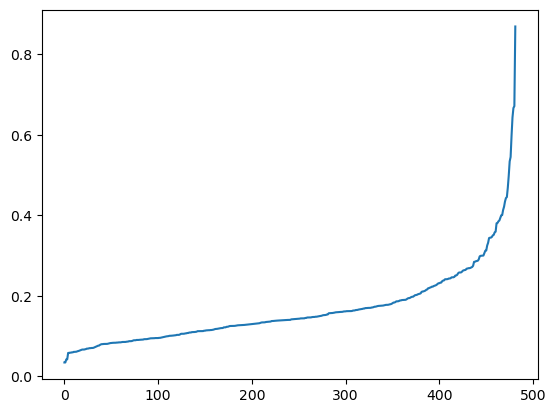

In [15]:
def find_optimal_eps(df):
    nn = NearestNeighbors(n_neighbors=2)
    nbrs = nn.fit(df)
    distances, indices = nbrs.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

find_optimal_eps(transformed_data)

- the optimal eps looks like it should be around 0.25 to 0.3, but when they're used in dbscan i only get like 1 to 2 clusters which doesn't make any sense

2. `minPts`: minimum number of data points to define a cluster. We will set this value to 2 because all we need is 2 stocks in a cluster to potentially have a cointegrated and therefore highly profitable pair.

These two parameters allow us to define the following 3 definitions.

1. **core point:** a point `x` such that there at least `minPts` number of points (inclusive of the point itself) in the closed ball $B_\epsilon(x)$.
2. **border point:** a point `x` such that it is reachable from a core point and there are less than `minPts` number of points within $B_\epsilon(x)$.
3. **outlier:** a point such that it is not a core point and it is not reachable from any core points.

The DBSCAN algorithm is as follows:

1. `minPts` and `eps` are predetermined. Suppose there exist $n$ data points $x_1, \cdots, x_n \in X$. Select a starting point $x_i$ at random.
2. Let $S$ be the set of all points in $B_\epsilon (x_i)$. If $|S| >= \ $ `minPts`, then $x_i$ is marked as a core point and cluster formation starts. Otherwise, the point is marked as noise. All other points $x_j \in B_{\epsilon}(x_i)$ become a part of the cluster. 
3. If for the other $x_j$, if there exists at least `minPts` in $B_\epsilon(x_j)$, then $x_j$ is also determined to be core points, then all $x_k \in B_\epsilon(x_j)$ are also added to the cluster and evaluated if they are core points.
4. Once that cluster is formed, choose another random point that has not been visited yet and follow the same procedure. Note that points that are marked as noise can be revisited.
5. The algorithm is done when all points classified as part of a cluster or a noise point.

In [16]:
def dbscan_cluster(transformed_data: np.ndarray) -> List[int]:
    db = DBSCAN(eps = 0.1, min_samples = 2)
    labels = db.fit_predict(transformed_data)
    # Count the number of clusters and noise points.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    clusters = {}
    for i in range(len(labels)):
        if labels[i] != -1:
            clusters[labels[i]] = clusters.get(labels[i], "") + str(tickers[i]) + " "
    clusters = dict(sorted(clusters.items(), key=lambda x:x[0]))
    # Print out some information.
    print("Estimated number of clusters:", n_clusters)
    print("Estimated number of noise points:", n_noise)
    cluster_info = pd.DataFrame({'Cluster': clusters.keys(), 'Stocks': clusters.values()})
    cluster_info = cluster_info.set_index('Cluster')
    display(cluster_info.head())
    return labels

start_dbscan = time.perf_counter()
labels_dbscan = dbscan_cluster(transformed_data)
pairs_dbscan = engle_granger_cointegration(close_data, labels_dbscan)
end_dbscan = time.perf_counter()
print(f"Time it takes DBSCAN to generate pairs in a 500 stock universe size: {end_dbscan - start_dbscan}")
print(f"DBSCAN found {len(pairs_dbscan)} pairs.")
pairs_dbscan.head()

Estimated number of clusters: 10
Estimated number of noise points: 370


,Stocks
Cluster,
0,ADBE ARE LNT AXP ABC ADSK BALL WRB BBY BIIB BL...
1,A EPAM HST NEE
2,AKAM ALK APA ANET CNP CMCSA CSX CMI DAL DVN DO...
3,AON AMAT BKNG CHD DPZ DTE EIX EL ITW KDP MS OR...
4,FICO FAST


Time it takes DBSCAN to generate pairs in a 500 stock universe size: 38.541569699999854
DBSCAN found 215 pairs.


,Pairs,PValues
0,"(HON, RJF)",0.000002
1,"(HON, WFC)",0.000064
2,"(NTRS, RF)",0.000093
3,"(AEP, SO)",0.000103
4,"(HON, LNC)",0.000114


,0,1,2
0,HON,Honeywell,Industrial Conglomerates
1,RJF,Raymond James,Investment Banking & Brokerage


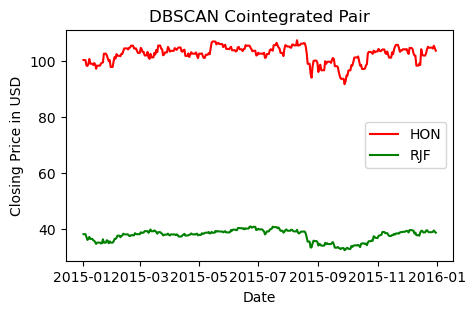

In [17]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(close_data['HON'], label = 'HON', color='red')
ax.plot(close_data['RJF'], label = 'RJF', color='green')
ax.set_title('DBSCAN Cointegrated Pair')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price in USD')
ax.legend()
fig.show()

hon_rjf = [(tickers[i], names[i], industries[i]) for i in range(len(tickers)) if tickers[i]=='HON' or tickers[i]=="RJF"]
pd.DataFrame(hon_rjf)

### OPTICS (Ordering Points to Identify Cluster Structure)

We observe firsthand that the Elbow Technique to determine optimal `eps` is unreliable and cumbersome. Such a small difference in the value of `eps` can drastically transform final results. This required level of precision for `eps` limits DBSCAN predominantly to the detection of clusters of similar density. OPTICS solves this issue 

In [13]:
def optics_cluster(transformed_data: array_1d) -> array_1d:
    optics = OPTICS(min_samples = 2)
    labels = optics.fit_predict(transformed_data)
    # Count clusters and noise points.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    # Organize the clusters.
    clusters = {}
    for i in range(len(labels)):
        if labels[i] != -1:
            clusters[labels[i]] = clusters.get(labels[i], "") + str(tickers[i]) + " "
    clusters = dict(sorted(clusters.items(), key=lambda x:x[0]))
    # Print out information about the clusters.
    print("Estimated number of clusters:", n_clusters)
    print("Estimated number of noise points:", n_noise)
    cluster_info = pd.DataFrame({'Cluster': clusters.keys(), 'Stocks': clusters.values()})
    cluster_info = cluster_info.set_index('Cluster')
    display(cluster_info.head())
    return labels
    
start_optics = time.perf_counter()
labels_optics = optics_cluster(transformed_data)
pairs_optics = engle_granger_cointegration(close_data, labels_optics)
end_optics = time.perf_counter()
print(f"Time it takes OPTICS to generate pairs in a 500 stock universe size: {end_optics - start_optics}")
print(f"OPTICS found {len(pairs_optics)} pairs.")
pairs_optics.head()

Estimated number of clusters: 39
Estimated number of noise points: 361


,Stocks
Cluster,
0,ABC BIIB LNC
1,AVGO SBUX
2,ARE EXR
3,BWA FLT HUM ODFL NOW TER UAL
4,ADBE PFE


Time it takes OPTICS to generate pairs in a 500 stock universe size: 8.990993400000207
OPTICS found 28 pairs.


,Pairs,PValues
0,"(AEP, SO)",0.000103
1,"(ES, PCG)",0.000236
2,"(AEP, PCG)",0.000566
3,"(AEE, XEL)",0.000607
4,"(AEE, CMS)",0.000917


,0,1,2
0,AEP,American Electric Power,Electric Utilities
1,SO,Southern Company,Electric Utilities


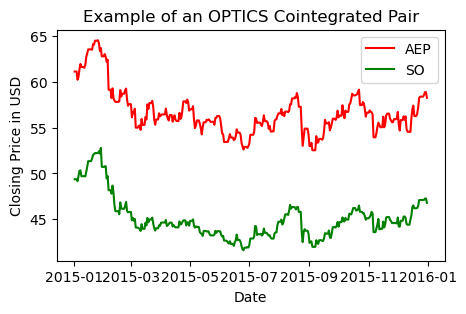

In [21]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(close_data["AEP"], label = "AEP", color="red")
ax.plot(close_data["SO"], label = "SO", color="green")
ax.set_title("Example of an OPTICS Cointegrated Pair")
ax.set_xlabel("Date")
ax.set_ylabel("Closing Price in USD")
ax.legend()
fig.show()

aep_so = [(tickers[i], names[i], industries[i]) for i in range(len(tickers)) if tickers[i]=="AEP" or tickers[i]=="SO"]
pd.DataFrame(aep_so)

## Testing KMeans vs. DBSCAN vs. OPTICS in Alphas

KMeans:   0%|          | 0/3 [00:00<?, ?it/s]

Done!: 100%|██████████| 3/3 [54:06<00:00, 1082.19s/it]   


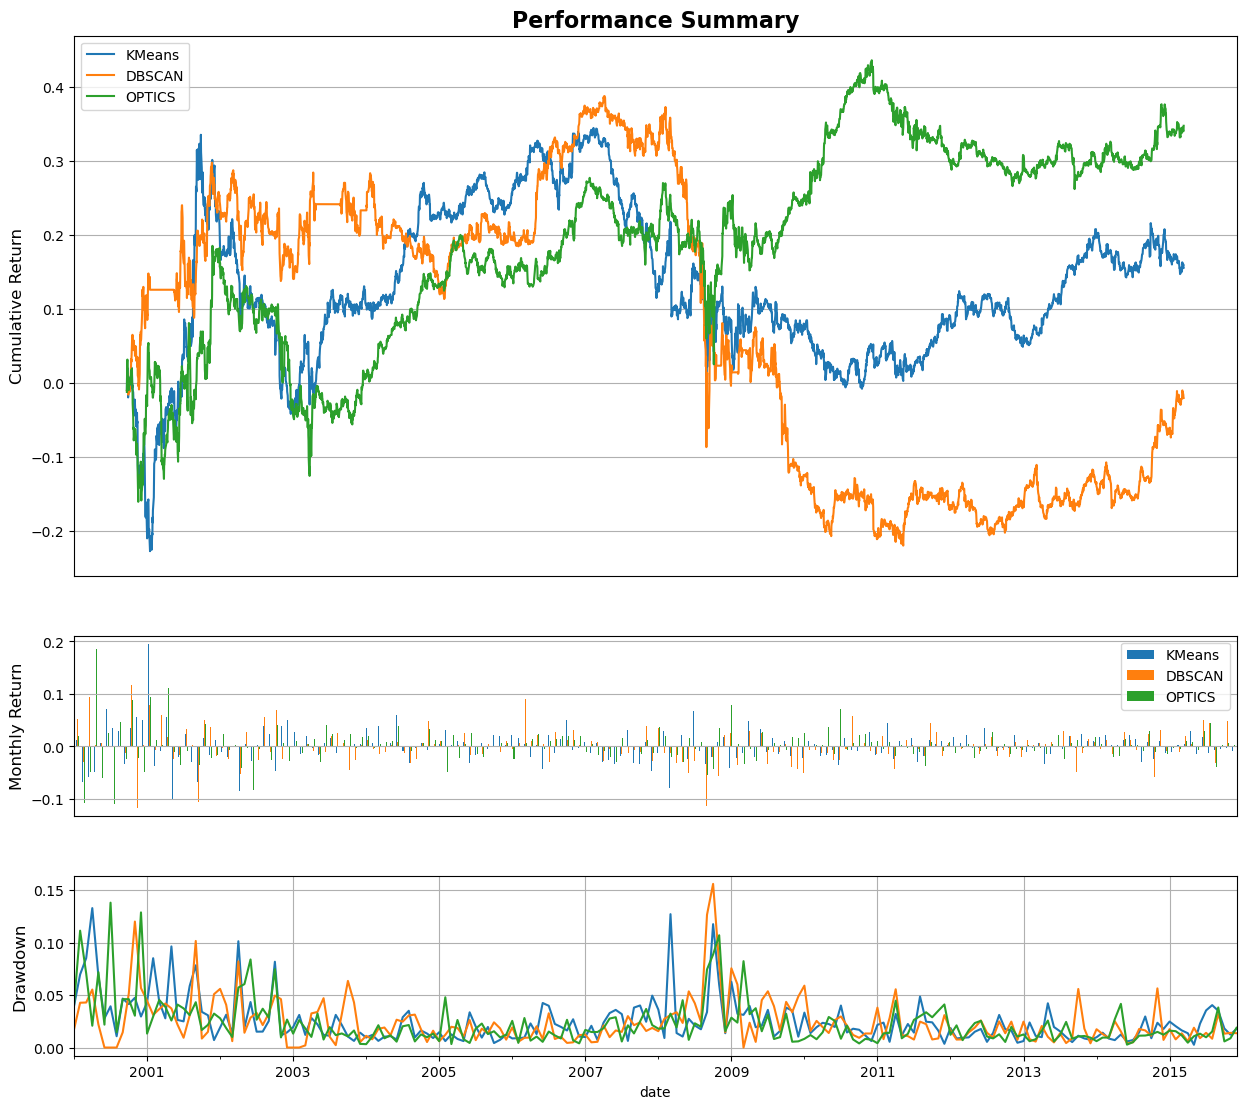

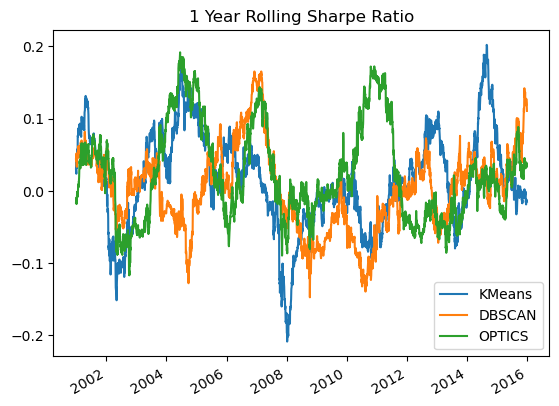

KMeans


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2000,0.089052,0.464051,0.663674,0.225421,0.184086,7.646825,6.646825
2001,0.023467,0.110781,0.196951,0.226715,0.204515,7.028226,6.028226
2002,-0.028538,-0.224848,-0.295218,0.151675,0.194013,7.634921,6.634921
2003,0.033300,0.472746,0.778729,0.043415,0.169414,8.198413,7.198413
2004,0.105337,1.653779,2.567109,0.052920,0.172115,7.761905,6.761905
2005,0.056537,1.017150,1.547513,0.055943,0.182552,7.726190,6.726190
2006,0.046355,0.549489,0.957048,0.089754,0.220166,7.227092,6.227092
2007,-0.173811,-2.712993,-3.969965,0.180830,0.152517,8.023904,7.023904
2008,-0.033351,-0.158840,-0.157039,0.213484,0.179908,8.019763,7.019763



DBSCAN


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2000,0.117486,0.685873,0.986626,0.124957,0.137217,4.908730,3.908730
2001,0.112642,0.795108,1.147820,0.138768,0.185090,5.774194,4.774194
2002,0.011672,0.090915,0.132496,0.102707,0.170791,5.281746,4.281746
2003,-0.044732,-0.485025,-0.678116,0.098259,0.065755,1.900794,0.900794
2004,-0.012710,-0.192773,-0.317929,0.103506,0.133017,6.559524,5.559524
2005,0.012214,0.207222,0.316500,0.044764,0.180898,6.023810,5.023810
2006,0.172897,2.406908,4.475402,0.040887,0.224275,5.968127,4.968127
2007,-0.046674,-0.614196,-0.864403,0.079637,0.202410,7.729084,6.729084
2008,-0.297555,-1.286043,-1.636773,0.377499,0.056136,3.075099,2.075099



OPTICS


,return,sharpe,sortino,drawdown,turnover,long count,short count
year,,,,,,,
2000,-0.054030,-0.256656,-0.419680,0.177287,0.159194,8.333333,7.333333
2001,0.135688,0.961985,1.653210,0.114663,0.177936,7.072581,6.072581
2002,-0.119351,-0.803452,-1.227172,0.217623,0.163300,7.551587,6.551587
2003,0.102737,1.568928,2.900014,0.037257,0.198823,7.468254,6.468254
2004,0.120434,2.342101,4.168433,0.023407,0.165144,7.924603,6.924603
2005,-0.027192,-0.532889,-0.864195,0.069132,0.201114,7.317460,6.317460
2006,0.113307,1.930679,2.709779,0.030491,0.174942,7.984064,6.984064
2007,-0.077533,-1.183704,-1.891123,0.111942,0.173135,8.115538,7.115538
2008,-0.047076,-0.273449,-0.392793,0.226139,0.166235,7.960474,6.960474


In [5]:
# Create KMeans alpha.
KMeans_Alpha = SMRPairsTrader(reset=90, npairs=10, enter=1.0, exit=0.5, cluster=Cluster.KMEANS)
KMeans_Alpha.name = "KMeans"
# Create DBSCAN alpha.
DBSCAN_Alpha = SMRPairsTrader(reset=90, npairs=10, enter=1.0, exit=0.5, cluster=Cluster.DBSCAN)
DBSCAN_Alpha.name = "DBSCAN"
# Create OPTICS alpha.
OPTICS_Alpha = SMRPairsTrader(reset=90, npairs=10, enter=1.0, exit=0.5, cluster=Cluster.OPTICS)
OPTICS_Alpha.name = "OPTICS"
alphas = [KMeans_Alpha, DBSCAN_Alpha, OPTICS_Alpha]
returns, holdings = backtester_15y.backtest(alphas, processes=6)
metrics.summary_plot(returns, source=["KMeans", "DBSCAN", "OPTICS"])
get_rolling_sharpe(returns)
get_analytics(alphas, returns, holdings)

## Clustering - Conclusion

Of the three methods, we select OPTICS to use in our final alpha moving forward. Although the OPTICS and kmeans clustering methods give similar performance, OPTICS runs much quicker, and kmeans is further limited by the need to manually select $k$. 

Thus, we will continue to build on our alpha using OPTICS as our clustering method for the rest of the notebook.

**Critically, notice that the performance of these alphas is similar/better than the original brute force lowest pvalue alpha. This is extremely important as it means we are losing minimal value by using clustering to reduce the number of pairs of securities we check cointegration between, while gaining massive computational advantage.**

## Time Complexity Analysis - Clustering vs. Original

The objective of principal component analysis and clustering methods is to identify cointegrated pairs faster and more efficiently. Thus, let us conduct a time complexity analysis of a bare bones pairs trading strategy versus an enhanced strategy when both are tested in a 500 stock universe. We also want to create a short 6 month backtester for the sole purpose of conducting this time complexity comparison.

In [8]:
# *** FOP TIME COMPLEXITY ANALYSIS *** #
# start_date_6m = datetime.datetime(2005, 1, 1)
# end_date_6m = datetime.datetime(2005, 6, 30)
# backtester_6m = fb.FullMultipleBacktester(
#     start_date_6m,
#     end_date_6m,
#     'M',
#     273,
#     universe_size = 500, 
#     factors=['close', 'sector']
# )
# backtester_6m.save_local('pairs_6m.npy')
backtester_6m = fb.FullMultipleBacktester.from_local("sif/pairstrading/pairs_6m.npy")

In [9]:
# Create and time the brute force alpha.
Brute_Force = SMRPairsTrader(reset=90, npairs=10, enter=1.0, exit=0.5, full_universe=True)
Brute_Force.name = "Brute Force Alpha"
alphas = [Brute_Force]
backtester_6m.backtest(alphas, processes=None)
# Create and time the efficient alpha.
OPTICS_Alpha = SMRPairsTrader(reset=90, npairs=10, enter=1.0, exit=0.5, cluster=Cluster.OPTICS)
OPTICS_Alpha.name = "OPTICS"
alphas = [OPTICS_Alpha]
backtester_6m.backtest(alphas, processes=None)

OPTICS: 100%|██████████| 1/1 [00:09<00:00,  9.17s/it]

Time for the Random Alpha: 2367.1301373 seconds
Time for the Enhanced Alpha: 9.18032200000016 seconds


# Pairs Trading Parameters

There are many parameters that we can tune for pairs trading to build the optimal strategy. In this portion of the notebook, we will explore them.

### Thresholds

We define opening and closing of trade thresholds for our trades by cutoff values of the z-score of the spread between the price timeseries of the two securities. Z-score is defined as $$z = \dfrac{x-\mu}{\sigma}$$ where $x$ is some value, $\mu$ is the mean, and $\sigma$ is the standard deviation, and this value represents the number of standard deviations away from the mean our current value is.

In [14]:
def zscore(series: np.ndarray) -> np.ndarray:
    return (series - series.mean()) / np.std(series)

### Open Position Criteria

A trade will be initialized (ie. we take a long position for the underperforming security and a short position on the overperforming security) when the absolute value of the zscore of the spread is greater than our open threshold, currently 1.0.
### Close Position Criteria

The trade will be closed when the asbolute value of the zscore of the spread becomes less than our close (take profit) threshold, which is currently 0.5. If this threshold is reached on an open position, it means the difference between close prices have revered back toward their mean and a profit should be made.

### Stop Loss Criteria

In the circumstance where two securities seem to continue to diverge beyond what we consider reasonable, we propose a mechanism for cutting our losses by exiting the trade. If the absolute of the zscore of the spread ever becomes greater than our stop loss threshold, we reevaluate the cointegration levels again using the Engel Granger test. If the resulting pvalue is greater than 0.05 (no longer cointegrated), we choose to suspect that the pair is no longer cointegrated, and we will exit the trade and take our losses before the securities further diverge and result in even greater losses.

In [15]:
pairs_dict = dict(np.array(pairs_optics))
# Sort the pairs by lowest pvalue.
keys = list(pairs_dict.keys())
values = list(pairs_dict.values())
args = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in args}
# Remove duplicates.
new_dict = {}
seen = set()
for (i, j) in sorted_dict:
    if i not in seen and j not in seen:
        new_dict[(i, j)] = sorted_dict[(i,j)]
        seen.add(i)
        seen.add(j)
new_dict

{('AEP', 'SO'): 0.00010311335184093613,
 ('ES', 'PCG'): 0.00023616839472712415,
 ('AEE', 'XEL'): 0.000607489196683425,
 ('PNW', 'WEC'): 0.006712663328868604,
 ('TFC', 'WFC'): 0.010048276260052003,
 ('ICE', 'NDAQ'): 0.013385651961030115,
 ('AMT', 'CCI'): 0.019179785400584348,
 ('CNP', 'DUK'): 0.02118190588615429,
 ('KO', 'PEP'): 0.027679852301689015,
 ('ETR', 'FE'): 0.032255794805052584,
 ('AON', 'MMC'): 0.03678558565665211,
 ('C', 'HBAN'): 0.03728784522538781,
 ('CI', 'UNH'): 0.04340813007877058}

In [16]:
# Define zscore thresholds.
OPEN = 1.0
CLOSE = 0.5
WINDOW = 90
# Define the data that we want to record.
factors = ['Zscore', 'Close Prices', 'Spread']
df = {factor : pd.DataFrame(np.zeros((180-WINDOW, len(new_dict)))) for factor in factors}
pairs = [pair for pair in new_dict]
# Populate these DataFrames with the appropriate format.
for factor in df:
    df[factor] = df[factor].rename_axis("Day")
    df[factor] = df[factor].set_axis(pairs, axis="columns")
    new_axis = [i for i in range(WINDOW, 180)]
    df[factor] = df[factor].set_axis(new_axis, axis="rows")
    df[factor] = df[factor].rename_axis(f"{factor} of Pairs", axis="columns")
    display(df[factor].head())

Zscore of Pairs,"(AEP, SO)","(ES, PCG)","(AEE, XEL)","(PNW, WEC)","(TFC, WFC)","(ICE, NDAQ)","(AMT, CCI)","(CNP, DUK)","(KO, PEP)","(ETR, FE)","(AON, MMC)","(C, HBAN)","(CI, UNH)"
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Close Prices of Pairs,"(AEP, SO)","(ES, PCG)","(AEE, XEL)","(PNW, WEC)","(TFC, WFC)","(ICE, NDAQ)","(AMT, CCI)","(CNP, DUK)","(KO, PEP)","(ETR, FE)","(AON, MMC)","(C, HBAN)","(CI, UNH)"
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Spread of Pairs,"(AEP, SO)","(ES, PCG)","(AEE, XEL)","(PNW, WEC)","(TFC, WFC)","(ICE, NDAQ)","(AMT, CCI)","(CNP, DUK)","(KO, PEP)","(ETR, FE)","(AON, MMC)","(C, HBAN)","(CI, UNH)"
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
for day in range(WINDOW, 180):
    for p in new_dict:
        # For each pair, get the last WINDOW prices as a time series.
        FIRST = (close_data[p[0]]).iloc[day-WINDOW:day]
        SECOND = (close_data[p[1]]).iloc[day-WINDOW:day]
        # Compute data that needs to be added to the DataFrames.
        close_price = f"({round(close_data[p[0]][day], 2)} , {round(close_data[p[1]][day], 2)})"
        spread = FIRST - SECOND
        z_score = zscore(spread).tail(1).values[0]
        diff = close_data[p[0]][day] - close_data[p[1]][day]
        # Now add the data to the DataFrames for each pair.
        for factor in factors:
            if factor == "Zscore":
                if z_score >= OPEN:
                    # Update current trade status.
                    df[factor][p][day] = f"OPEN {round(z_score, 2)}"
                # Exit the trade; dont increment anything.
                elif abs(z_score) <= CLOSE:
                    df[factor][p][day] = f"CLOSED {round(z_score, 2)}"
                # Enter the trade; long the FIRST, short SECOND.
                elif z_score <= -OPEN:
                    df[factor][p][day] = f"OPEN {round(z_score, 2)}"
            # Record the close prices and spreads.
            elif factor == "Close Prices":
                df[factor][p][day] = close_price
            elif factor == "Spread":
                df[factor][p][day] = round(diff, 2)

In [ ]:
for factor in factors:
    print(df[factor].to_markdown())
    print()

See the `eda_traced.py` file for the results.

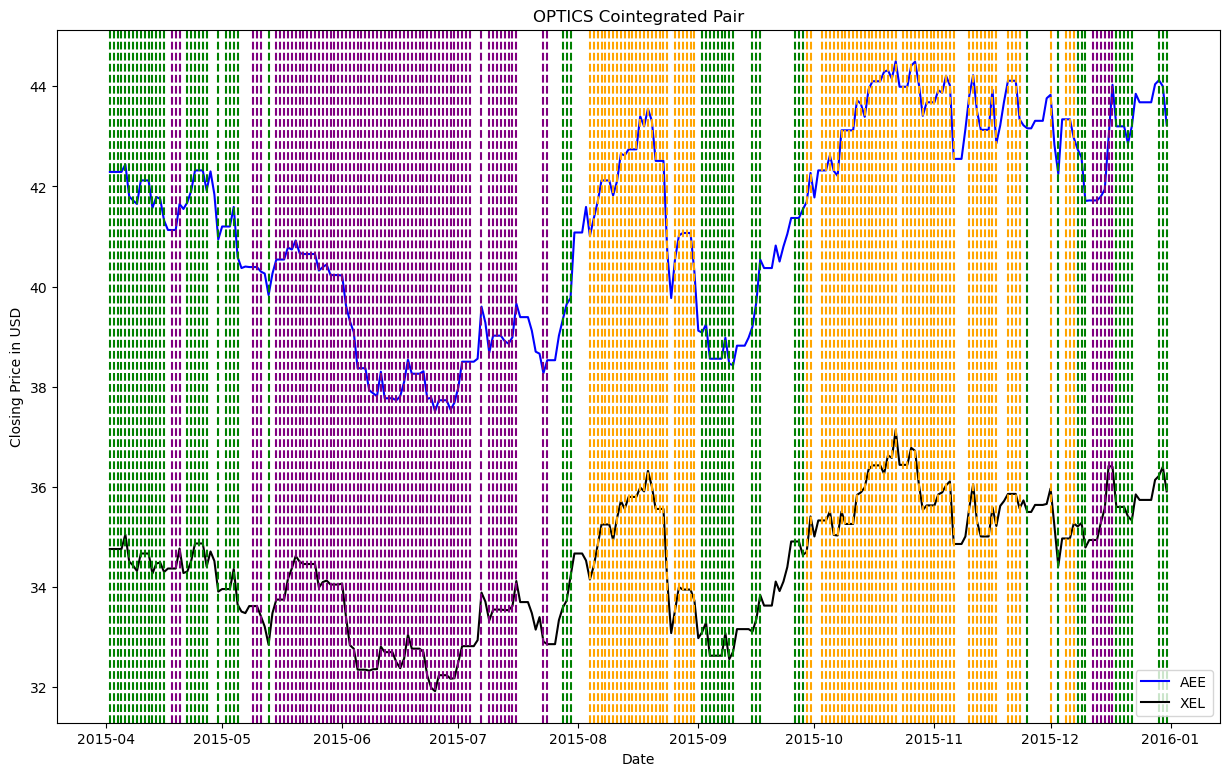

In [19]:
aee = pd.DataFrame(close_data["AEE"])
xel = pd.DataFrame(close_data["XEL"])
aee_2 = aee[WINDOW:]
xel_2 = xel[WINDOW:]

fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(aee_2, label = 'AEE', color='blue')
ax.plot(xel_2, label = 'XEL', color='black')

for day in range(WINDOW, len(aee)):
    aee_2 = aee.iloc[day-WINDOW:day]
    xel_2 = xel.iloc[day-WINDOW:day]
    spread = aee_2['AEE'] - xel_2['XEL']
    z_score = zscore(spread).tail(1).values[0]
    if z_score > OPEN:
        plt.axvline(x=(aee.reset_index())['date'][day], color='orange', linestyle='--')
    elif abs(z_score) < CLOSE:
        plt.axvline(x=(aee.reset_index())['date'][day], color='green', linestyle='--')
    elif z_score < -OPEN:
        plt.axvline(x=(aee.reset_index())['date'][day], color='purple', linestyle='--')

ax.set_title('OPTICS Cointegrated Pair')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price in USD')
ax.legend()
fig.show()

## Information about the OPTICS Pairs
- The number of pairs trades opened.
- The average length of trade opened.
- Generate a graph of the zscore distributions.

In [20]:
# *** NUMBER OF PAIR TRADES OPENED *** #
pair_to_status = {pair : [0, False] for pair in new_dict}
# *** AVERAGE CHANGE IN ZSCORE FOR EACH PAIR *** #
pair_to_delta_zscore = {pair : [0, 0, 0] for pair in new_dict}
# *** MAX, MIN CHANGE IN ZSCORE FOR EACH PAIR *** #
pair_to_minmax_zscore = {pair : [0, 0] for pair in new_dict}
pos = 0
neg = 0
# *** NUMBER OF PAIR TRADES CLOSED *** #
pair_to_close = {pair : 0 for pair in new_dict}
# *** TOTAL LENGTH OF EACH TRADE OPENED *** #
pair_to_total_time = {pair : 0 for pair in new_dict}
# *** AVERAGE LENGTH OF EACH TRADE OPENED *** #
pair_to_average_time = {pair : 0 for pair in new_dict}
# *** ZSCORE FREQUENCY *** #
zscore_freq = {}

In [21]:
for day in range(WINDOW, len(close_data)):
    for p in new_dict:
        # FIRST and SECOND are indices of the stocks.
        FIRST = (close_data[p[0]]).iloc[day-WINDOW:day]
        SECOND = (close_data[p[1]]).iloc[day-WINDOW:day]
        # Compute the spread.
        spread = FIRST - SECOND
        # The zscore tells us how far from away from the mean a point is.
        z_score = zscore(spread).tail(1).values[0]
        # Update the data as necessary.
        if z_score > 0:
            pair_to_delta_zscore[p][0] += z_score 
            pos += 1
            pair_to_minmax_zscore[p][0] = max(z_score, pair_to_minmax_zscore[p][0])
        else:
            pair_to_delta_zscore[p][1] += z_score 
            neg += 1
            pair_to_minmax_zscore[p][1] = min(z_score, pair_to_minmax_zscore[p][1])
        pair_to_delta_zscore[p][2] += z_score 
        # Round the zscore to the nearest tenth.
        tempZ = round(z_score, 1)
        zscore_freq[tempZ] = zscore_freq.get(tempZ, 0) + 1
        # Enter the trade; short FIRST, long SECOND.
        if z_score >= OPEN:
            # Update current trade status.
            if not pair_to_status[p][1]:
                # Update the current number of trades.
                pair_to_status[p][0] += 1
                pair_to_status[p][1] = True
            pair_to_total_time[p] += 1
        # Exit the trade.
        elif abs(z_score) <= CLOSE:
            if pair_to_status[p][1]:
                pair_to_status[p][1] = False
                pair_to_close[p] += 1
        # Enter the trade; long the FIRST, short SECOND.
        elif z_score <= -OPEN:
            if not pair_to_status[p][1]:
                # Increment number of trades.
                pair_to_status[p][0] += 1
                pair_to_status[p][1] = True
            pair_to_total_time[p] += 1

In [22]:
for pair in pair_to_average_time:
    # Average time per trade = total time opened / number of trades.
    pair_to_average_time[pair] = pair_to_total_time[pair] / pair_to_status[pair][0]
    pair_to_delta_zscore[pair][0] = round(pair_to_delta_zscore[pair][0]/pos, 4)
    pair_to_delta_zscore[pair][1] = round(pair_to_delta_zscore[pair][1]/neg, 4)
    pair_to_delta_zscore[pair][2] = round(pair_to_delta_zscore[pair][2]/(pos+neg), 4)
# Create a DataFrame represnting all of the collected information.
pairs_info = pd.DataFrame({'Pair': pair_to_status.keys(),
                           'Pvalues': new_dict.values(), 
                           'Number of Trades Opened': pair_to_status.values(),
                           'Number of Trades Closed': pair_to_close.values(),
                           'Total Time Open': pair_to_total_time.values(), 
                           'Average Time Open': pair_to_average_time.values(), 
                           'Average Changes in Zscore': pair_to_delta_zscore.values(), 
                           'Max Min Changes in Zscore': pair_to_minmax_zscore.values()})
display(pairs_info)

,Pair,Pvalues,Number of Trades Opened,Number of Trades Closed,Total Time Open,Average Time Open,Average Changes in Zscore,Max Min Changes in Zscore
0,"(AEP, SO)",0.000103,"[19, False]",19,86,4.526316,"[0.0462, -0.083, -0.0173]","[2.546223658132979, -2.805683978017266]"
1,"(ES, PCG)",0.000236,"[14, False]",14,115,8.214286,"[0.0811, -0.0656, 0.009]","[2.7595367806628275, -3.366363741820063]"
2,"(AEE, XEL)",0.000607,"[8, False]",8,153,19.125000,"[0.0883, -0.0872, 0.0021]","[2.6199746024438033, -2.940468762540469]"
3,"(PNW, WEC)",0.006713,"[11, False]",11,116,10.545455,"[0.0589, -0.0921, -0.0153]","[2.456090906426008, -4.148591408595112]"
4,"(TFC, WFC)",0.010048,"[10, False]",10,117,11.700000,"[0.0578, -0.0789, -0.0093]","[2.5084880654723043, -2.459876269982127]"
5,"(ICE, NDAQ)",0.013386,"[11, False]",11,105,9.545455,"[0.0892, -0.0515, 0.0201]","[3.86429936699181, -1.7148936705082087]"
6,"(AMT, CCI)",0.019180,"[8, True]",7,107,13.375000,"[0.0873, -0.0596, 0.0151]","[2.7888479663384755, -2.3162201768282635]"
7,"(CNP, DUK)",0.021182,"[9, False]",9,94,10.444444,"[0.0983, -0.0287, 0.0359]","[2.617495176007438, -2.141518697707571]"
8,"(KO, PEP)",0.027680,"[12, False]",12,96,8.000000,"[0.0562, -0.0803, -0.0109]","[2.7287408587211064, -2.5393415245559834]"
9,"(ETR, FE)",0.032256,"[8, True]",7,131,16.375000,"[0.0269, -0.1451, -0.0576]","[1.8231564807457683, -3.36430809979007]"


Below is a graph of the zscore distributions. Note that it follows a normal distribution. 

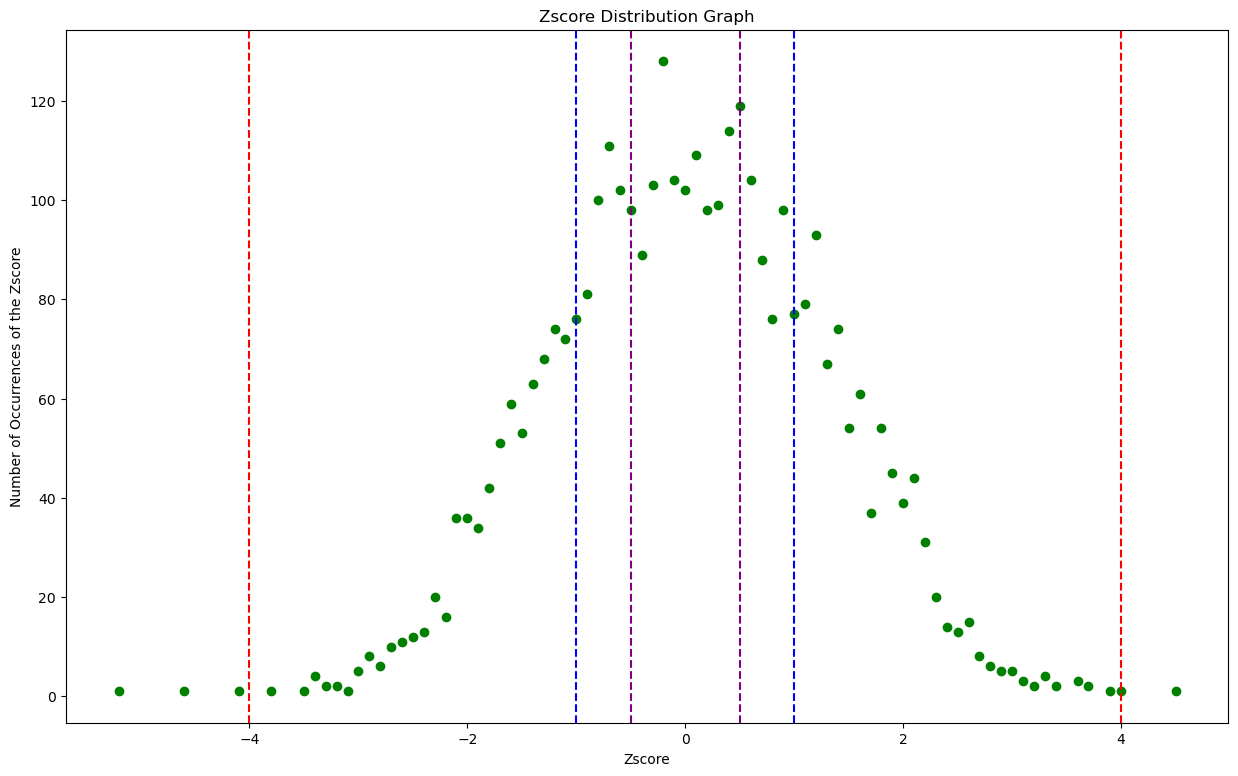

In [23]:
fig, ax = plt.subplots(figsize=(15, 9))
for z in zscore_freq:
    ax.plot(z, zscore_freq[z], 'go')
ax.axvline(x = -1, color='blue', linestyle='--')
ax.axvline(x = 1, color='blue', linestyle='--')
ax.axvline(x = -0.5, color='purple', linestyle='--')
ax.axvline(x = 0.5, color='purple', linestyle='--')
ax.axvline(x = -4.0, color='red', linestyle='--')
ax.axvline(x = 4.0, color='red', linestyle='--')
ax.set_title('Zscore Distribution Graph')
ax.set_xlabel('Zscore')
ax.set_ylabel('Number of Occurrences of the Zscore')
fig.show()

## Further Improvements

We added a stop loss condition such that if a pair's spread continues to diverge, we will recheck the pair's cointegration. If the pair is no longer cointegrated, then we will exit the trade immediately and eat our current losses before the spread can further diverge.

See `alphas.py` for implementation.

## Alpha Search Optimization (Parameter Optimization)

Previously, we used a zscore of 0.5 as the open threshold and 1.0 as the close threshold for our trades, which is entirely arbitrary. Arguments can be made open and close value thresholds. For example, increasing the window between open and close thresholds could result in larger profit margins but less trades being finished and vice versa. Rather than guessing and moving forward, let us Alpha Search from our SIF Infrastructure to test multiple values of our enter and exit conditions simultaneously with multiprocessing. A demo on parameter optimization can be found in the SIF Docs.

In [7]:
class AlphaParameterOptimization(AbstractAlpha):
    """
    This type of pairs trading algorithm has customizable trading thresholds,
    but they are not dynamic. We call this simple mean reversion (SMR).
    """
    def __init__(self, reset: int, 
                 npairs: int, 
                 enter: int, 
                 exit: int,
                 stop: int):
        # Required variables for AbstractAlpha
        self.name = "Alpha Parameter Optimization"
        self.lookback = reset
        self.factor_list = ['close']
        self.universe_size = 500
        # Variables for Pairs Trading Alpha
        self.pairs = None
        self.reset = reset
        self.npairs = npairs
        self.enter = enter
        self.exit = exit
        self.stop = stop
        self.holdings = np.zeros(self.universe_size)
        self.day_counter = 0
    
    def reduce_dimensionality(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Implements principal component analysis.
        :param df: close price data
        :return: 90% of the preserved information
        """
        # Obtain returns, drop NaN values, and transpose.
        rets = df.pct_change().dropna()
        rets = rets.T
        # Use Sklearn implementation.
        pca = PCA(n_components=0.9, svd_solver="full")
        transformed_data = pca.fit_transform(rets)
        return transformed_data

    def cluster_optics(self, transformed_data: pd.DataFrame, 
                       min_samples: int) -> List[int]:
        """
        Implements optics clustering.
        :param: transformed_data: output of principal component analysis
        :param min_samples: minimm samples to be a cluster
        :return: labels
        """
        optics = OPTICS(min_samples=min_samples)
        labels = optics.fit_predict(transformed_data)
        return labels

    def engle_granger_cointegration(self, df: pd.DataFrame, 
                                    labels: List[int]) -> Dict:
        """
        If two stocks are in the same cluster, as specified by the labels 
        array, then perform the Engel Granger Test for Cointegration.
        :param df: close data
        :param labels: output from clustering
        :return: Dictionary with pairs as keys and pvalues as values
        """
        # n is the number of assets in our universe
        n = df.shape[1]
        # For earlier alphas, if we choose not to cluster, then just set n = 50.
        if not self.full_universe and self.cluster == Cluster.NONE:
            n = 50
        # Keys are their column index. 
        keys = df.keys()
        # Initalize the dictionary that we will return.
        pairs_dict = {}
        # Iterate through all possible combinations of pairs.
        for i in range(n):
            for j in range(i + 1, n):
                # Proceed if the stocks are in the same cluster and not outliers.
                if labels[i] != -1 and labels[j] != -1 and labels[i] == labels[j]:
                    # Isolate the two stocks and drop NaNs.
                    S1 = df[keys[i]]
                    S2 = df[keys[j]]
                    coint_df = pd.DataFrame({"S1": S1, "S2": S2}).dropna()
                    S1 = coint_df["S1"]
                    S2 = coint_df["S2"]
                    # Ensure that the two time series are not constant.
                    if S1.nunique() > 1 and S2.nunique() > 1:
                        pvalue = coint(S1, S2)[1]
                        # Include this pair if it rejects the null hypothesis.
                        if pvalue < 0.05:
                            # Validate the mean reversion of the spread with hurst.
                            if self.use_hurst:
                                diff = list(S1 - S2)
                                lags = min(int(4 + len(diff) / 3), 100)
                                h_exp = self.hurst(pd.DataFrame(diff), lags)
                                if h_exp < 0.5:
                                    if self.hurst_sort:  
                                        pairs_dict[(i, j)] = h_exp
                                    else:
                                        pairs_dict[(i, j)] = pvalue   
                        # Else just add it to the dictionary.
                        else:
                            pairs_dict[(i, j)] = pvalue
        return pairs_dict
    
    def lowest(self, pairs_dict: Dict) -> List[Tuple]:
        """
        Returns the list of pairs sorted by lowest pvalue or hurst.
        :param pairs_dict: Dictionary with keys as pairs and values as pvalues or hurst exponents.
        :return: list of pairs sorted by lowest pvalue or hurst exponent.
        """
        # Obtain the keys and values of the pairs dictionary.
        keys = list(pairs_dict.keys())
        values = list(pairs_dict.values())
        # Argsort the values such that we can obtain the keys in that order.
        args = np.argsort(values)
        return [keys[i] for i in args]

    def remove_duplicates(self, pairs: List[Tuple]) -> List[Tuple]:
        """
        Ensures that one stock can only appear in our list of pairs once to 
        prevent mishaps with our self.holdings array.
        :param: list of pairs
        :return: list of pairs without duplicate stocks.
        """
        res = []
        seen = set()
        # Iterate through all cointegrated pairs.
        for (i, j) in pairs:
            # Only proceed if both stocks have not been seen before.
            if i not in seen and j not in seen:
                res.append((i, j))
                seen.add(i)
                seen.add(j)
        return res

    def form_pairs(self, df: pd.DataFrame) -> List[int]:
        """
        We will use principal component analysis, optics clustering, and 
        cointegration tests for the most part.
        :param df: close price data
        :return: a list of pairs
        """
        df = pd.DataFrame(df).dropna()
        n = df.shape[1]
        # Principal component analysis.
        transformed_data = self.reduce_dimensionality(df)
        # Researcher's choice of clustering algorithm.
        labels = self.cluster_optics(transformed_data, 2)
        # Pairs identification with or without hurst exponent validation.
        pairs_dict = self.engle_granger_cointegration(df, labels)
        # Pairs selection.
        pairs = self.lowest(pairs_dict)
        pairs = self.remove_duplicates(pairs)
        return pairs if self.npairs > len(pairs) else pairs[0: self.npairs]
    
    def zscore(self, series: pd.Series) -> float:
        """
        Normalizes the spread of the two cointegrated stocks.
        :param: the spread
        :return: the zscore
        """
        return (series - series.mean()) / np.std(series)
    
    def generate_day(self, day: datetime.datetime, data: pd.DataFrame) -> List[float]:
        """
        Mechanically trade using fixed trading thresholds.
        :param df: close price data
        :return: weights
        """
        # Create new pairs after self.reset days.
        if self.day_counter == 0:
            self.day_counter = self.reset
            self.holdings = np.zeros(self.universe_size)
            self.pairs = self.form_pairs(data["close"])
        # Isolate only the close price data.
        data = pd.DataFrame(data["close"])
        for p in self.pairs:
            # These are the two stocks, corresponding to column indices.
            FIRST = p[0]
            SECOND = p[1]
            # Calculate the current zscore of the spread.
            spread = data[FIRST] - data[SECOND]
            zscore = self.zscore(spread).tail(1).values[0]
            # Enter a trade here.
            if zscore >= self.enter and zscore <= self.stop:
                self.holdings[FIRST] = -1
                self.holdings[SECOND] = 1
            # Exit the trade here.
            elif abs(zscore) <= self.exit:
                self.holdings[FIRST] = 0
                self.holdings[SECOND] = 0
            # Consider our stop loss.
            elif abs(zscore) > self.stop:
                S1 = data[FIRST]
                S2 = data[SECOND]
                coint_df = pd.DataFrame({"S1": S1, "S2": S2}).dropna()
                S1 = coint_df["S1"]
                S2 = coint_df["S2"]
                if S1.nunique() > 1 and S2.nunique() > 1:
                    pvalue = coint(S1, S2)[1]
                    if pvalue >= 0.05:
                        self.holdings[FIRST] = 0
                        self.holdings[SECOND] = 0
                        self.pairs.remove(p)
            # Enter a trade here too.
            elif zscore <= -self.enter and zscore >= -self.stop:
                self.holdings[FIRST] = 1
                self.holdings[SECOND] = -1
        # Decrement day counter at the end of the day.
        self.day_counter -= 1
        return op.weight(self.holdings)

In [8]:
param_grid = {'reset': [90], 'npairs': [10, 25], 'enter': [2, 2.5, 3], 
              'exit': [1.0, 1.5, 2], 'stop': [3.5]}
result = alpha_search.grid_search(AlphaParameterOptimization, 
                    backtester_15y, 'return', param_grid, processes=6)
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(result.alpha_returns.cumsum())
# plt.legend(param_grid[('enter')], title='enter')
plt.title('Cumulative Returns')
plt.show()
result.__dict__

0:   0%|          | 0/18 [00:00<?, ?it/s]

Refer to the `alphaparameteroptimization1.py` file for the full results.

The best performing alpha had the following parameters:
- Reset: 90
- Npairs: 25
- Enter: 2
- Exit: 2
- Stop: 3.5
and it had cumulative returns of ___.

The worst performing alpha had the following parameters:
- Reset: 90
- Npairs: 25
- Enter: 2
- Exit: 2
- Stop: 3.5
and it had cumulative returns of ___.

There are a few key takeaways here.
1. More pairs typically outperforms less pairs.
2. The most profitable window to place our enter and exit thresholds are around the 2.0 zscore range.

Let us perform another alpha parameter optimization with these takeaways in mind. Note that in this trial, we will set `npairs = sys.maxsize` such that we trade all cointegrated pairs, and we will experiment with the stop loss condition now.

In [ ]:
param_grid = {'reset': [90], 'npairs': [sys.maxsize], 'enter': [2.1, 2.25], 
              'exit': [1.75, 1.9], 'stop': [2.5, 2.75, 3, 3.25]}
result = alpha_search.grid_search(AlphaParameterOptimization, backtester_15y, 'return', 
                                  param_grid, processes=6)
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(result.alpha_returns.cumsum())
plt.title('Cumulative Returns')
plt.show()
result.__dict__

Refer to the `alphaparameteroptimization2.py` file for the full results.

The best performing alpha had the following parameters:
- Reset: 90
- Npairs: 25
- Enter: 2
- Exit: 2
- Stop: 3.5
and it had cumulative returns of ___.

The worst performing alpha had the following parameters:
- Reset: 90
- Npairs: 25
- Enter: 2
- Exit: 2
- Stop: 3.5
and it had cumulative returns of ___.


## Pair Validation Techniques: Hurst Exponent (And profitability)

https://www.sciencedirect.com/science/article/pii/S037843712100964X?via%3Dihub

The Hurst Exponent measures long term memory and fractility of a time series. A Brownian random process is given by a hurst exponent of exactly 0.5, while a hurst exponent between 0.5 and 1 indicates a trending behavior. If the metric is between 0 and 0.5, the time series exhibits a mean reverting behavior. This is optimal for a pairs trading strategy.

Since in general, a hurst exponent != 0.5 means that the time series exhibits some sort of predictable pattern, we can use this metric to better trade on trending/momentum strategies with large hurst exponents, or mean reverting strategies like pairs trading with low hurst exponents.

In the next Alpha, we implement Hurst Exponent as a Validation technique to insure the pair is mean reverting in addition to cointegrated. We can consider weighting / selecting final pairs based on hurst in a later alpha, but for now, we simply require a cutoff for the metric x, where x < 0.5.

The code for calculating hurst comes from here: https://stackoverflow.com/questions/39488806/hurst-exponent-in-python


In [ ]:
def hurst(p):
    lags = range(2,100)
    variancetau, tau = [], []
    for lag in lags: 
        tau.append(lag) # Write the different lags into a vector to compute a set of tau or lags
        
        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = np.subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    # plot the log of those variance against the log of tau and get the slope
    m = np.polyfit(np.log10(tau), np.log10(variancetau), 1)
    hurst = m[0] / 2
    return hurst

print("HURST ON STOCKS\n")
print(len(hurst(close_data)), len(close_data.columns)) # make sure function works properly
h_exp = hurst(close_data)
print(h_exp[:25])
print("Mean:", h_exp.mean())
print("Min:", h_exp.min())
print("Max:", h_exp.max())

indices = np.argsort(h_exp)[:7]
for i in indices:
    plt.plot(close_data.iloc[:, i])
    print(h_exp[i])
plt.title("Lowest Hurst")
plt.show()

indices2 = np.argsort(h_exp)[-7:]
for i in indices2:
    print(h_exp[i])
    plt.plot(close_data.iloc[:, i])
plt.title("Highest Hurst")
plt.show()

print("HURST ON PAIRS")
pair = ("ATVI", "STZ")
pair2 = ("AEE", "XEL")

tspair = close_data["ATVI"] - close_data["STZ"]
tspair2 = close_data["AEE"] - close_data["XEL"]
tspairs = (tspair, tspair2)

for i in tspairs:
    plt.plot(i)
    plt.title((hurst(list(i))))
    plt.show()